<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Загрузка-и-ознакомление-с-данными" data-toc-modified-id="Загрузка-и-ознакомление-с-данными-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка и ознакомление с данными</a></span></li><li><span><a href="#Предварительная-обработка" data-toc-modified-id="Предварительная-обработка-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Предварительная обработка</a></span><ul class="toc-item"><li><span><a href="#Дубликаты" data-toc-modified-id="Дубликаты-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Дубликаты</a></span></li><li><span><a href="#Пропуски" data-toc-modified-id="Пропуски-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Пропуски</a></span></li></ul></li><li><span><a href="#Разведочный-анализ" data-toc-modified-id="Разведочный-анализ-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Разведочный анализ</a></span></li><li><span><a href="#Разработка-новых-синтетических-признаков" data-toc-modified-id="Разработка-новых-синтетических-признаков-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Разработка новых синтетических признаков</a></span></li><li><span><a href="#Проверка-на-мультиколлинеарность" data-toc-modified-id="Проверка-на-мультиколлинеарность-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Проверка на мультиколлинеарность</a></span></li><li><span><a href="#Отбор-финального-набора-обучающих-признаков" data-toc-modified-id="Отбор-финального-набора-обучающих-признаков-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Отбор финального набора обучающих признаков</a></span></li><li><span><a href="#Выбор-и-обучение-моделей" data-toc-modified-id="Выбор-и-обучение-моделей-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Выбор и обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Модель-LogisticRegression" data-toc-modified-id="Модель-LogisticRegression-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Модель LogisticRegression</a></span></li><li><span><a href="#Модель-RandomForestClassifier" data-toc-modified-id="Модель-RandomForestClassifier-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Модель RandomForestClassifier</a></span></li><li><span><a href="#Модель-CatBoostClassifier" data-toc-modified-id="Модель-CatBoostClassifier-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Модель CatBoostClassifier</a></span></li></ul></li><li><span><a href="#Итоговая-оценка-качества-предсказания-лучшей-модели" data-toc-modified-id="Итоговая-оценка-качества-предсказания-лучшей-модели-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Итоговая оценка качества предсказания лучшей модели</a></span></li><li><span><a href="#Анализ-важности-ее-признаков." data-toc-modified-id="Анализ-важности-ее-признаков.-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Анализ важности ее признаков.</a></span></li></ul></div>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
! pip install phik
! pip install catboost

In [3]:
import warnings
import regex

import phik
from phik.report import plot_correlation_matrix
from phik import report

import seaborn as sns
import plotly.express as px

from sklearn.model_selection import (train_test_split,
                                     GridSearchCV)
from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder,
                                   StandardScaler)                                 
from sklearn.compose import (make_column_transformer,
                             make_column_selector)
from sklearn.pipeline import make_pipeline


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


from catboost import (cv,
                      Pool,
                      CatBoostClassifier)

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

RANDOM_STATE = 42

# Предсказание жанра музыки 

## Описание проекта

Вы сотрудник Отдела Data Science популярного музыкального стримингового сервиса. Сервис расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача -- правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. Ваши коллеги из отдела работы со звуком подготовили датасет, в котором собраны некоторые характеристики музыкальных произведений и их жанры. Ваша задача -- разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

**Данные**
* train.csv - информация (~20000) музыкальных треках, которые будут использоваться в качестве обучающих данных.
* test.csv - информация (~5000) музыкальных треках, которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение 'music_genre' для каждого трека из этого датасета.
* sample_submit.csv - файл предсказаний в правильном формате.

**Описание полей данных**  
`instance_id` - уникальный идентификатор трека  
`track_name` - название трека  
`acousticness` - акустичность  
`danceability` - танцевальность  
`duration_ms` -продолжительность в милисекундах  
`energy` - энергичность  
`instrumentalness` - инструментальность  
`key` - базовый ключ (нота) произведения  
`liveness` - привлекательность  
`loudness` - громкость  
`mode` - указывает на модальность (мажорную или минорную) трека  
`speechiness` - выразительность  
`tempo` - темп  
`obtained_date` - дата загрузки в сервис  
`valence` - привлекательность произведения для пользователей сервиса  
`music_genre` - музыкальный жанр  

## Загрузка и ознакомление с данными

In [29]:
# df_train = pd.read_csv('/kaggle/input/kaggle-music-genre/kaggle_music_genre_train.csv')
# df_test = pd.read_csv('/kaggle/input/kaggle-music-genre/kaggle_music_genre_test.csv')
df_train = pd.read_csv('./datasets/kaggle_music_genre_train.csv')
df_test = pd.read_csv('./datasets/kaggle_music_genre_test.csv')

In [30]:
def get_data_info(df):
    display(df.sample(5))
    display(df.info())
    display(df.describe(include='all').transpose())

In [31]:
get_data_info(df_train)

instance_id                track_name  acousticness  danceability  \
19361      22145.0  Chiisana Hoshino Merodii      0.164000         0.467   
10165      44158.0                  Ugly Boy      0.014700         0.822   
4286       64693.0               4th of July      0.006320         0.546   
220        55338.0               New Orleans      0.274000         0.500   
17261      56995.0                  Fireball      0.000595         0.552   

       duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
19361     311467.0   0.496           0.00000   E     0.340    -6.621  Major   
10165     213607.0   0.669           0.00000  A#     0.188    -5.358  Minor   
4286      180053.0   0.837           0.19600   G     0.371    -6.930  Major   
220       241640.0   0.938           0.00000   C     0.596    -3.741  Major   
17261     202440.0   0.962           0.00333   B     0.174    -7.875  Minor   

       speechiness    tempo obtained_date  valence music_genre  
19361       0.0305  169.703         4-Apr    0.532       Anime  
10165       0.1820  102.035         4-Apr    0.602        Rock  
4286        0.0540  140.941         4-Apr    0.548       Blues  
220         0.0667  161.522         4-Apr    0.902       Blues  
17261       0.0646      NaN         4-Apr    0.885       Blues

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

None

count unique    top   freq           mean            std  \
instance_id       20394.0    NaN    NaN    NaN   55973.846916   20695.792545   
track_name          20394  18643   Home     11            NaN            NaN   
acousticness      20394.0    NaN    NaN    NaN       0.274783       0.321643   
danceability      20394.0    NaN    NaN    NaN       0.561983       0.171898   
duration_ms       20394.0    NaN    NaN    NaN  220375.425272  126728.326142   
energy            20394.0    NaN    NaN    NaN       0.625276       0.251238   
instrumentalness  20394.0    NaN    NaN    NaN       0.159989       0.306503   
key                 19659     12      G   2304            NaN            NaN   
liveness          20394.0    NaN    NaN    NaN        0.19854       0.166742   
loudness          20394.0    NaN    NaN    NaN      -8.552998       5.499917   
mode                19888      2  Major  12828            NaN            NaN   
speechiness       20394.0    NaN    NaN    NaN       0.091352       0.097735   
tempo             19952.0    NaN    NaN    NaN     120.942522       30.42759   
obtained_date       20394      4  4-Apr  18435            NaN            NaN   
valence           20394.0    NaN    NaN    NaN       0.464588       0.243387   
music_genre         20394     10  Blues   2858            NaN            NaN   

                      min       25%       50%        75%        max  
instance_id       20011.0  38157.25   56030.0   73912.75    91758.0  
track_name            NaN       NaN       NaN        NaN        NaN  
acousticness          0.0    0.0152      0.12       0.47      0.996  
danceability         0.06     0.451      0.57      0.683      0.978  
duration_ms          -1.0  177517.0  219533.0   266000.0  4497994.0  
energy            0.00101      0.47     0.666       0.83      0.999  
instrumentalness      0.0       0.0  0.000144   0.084475      0.996  
key                   NaN       NaN       NaN        NaN        NaN  
liveness           0.0136    0.0973      0.13      0.253        1.0  
loudness          -44.406 -10.25575    -7.052     -5.054      3.744  
mode                  NaN       NaN       NaN        NaN        NaN  
speechiness        0.0223    0.0356   0.04905   0.095575      0.942  
tempo              34.765  95.92175  120.0125  141.96625    220.041  
obtained_date         NaN       NaN       NaN        NaN        NaN  
valence               0.0     0.272     0.457      0.653      0.992  
music_genre           NaN       NaN       NaN        NaN        NaN

В данных есть пропуски в колонках:
* `key`
* `mode`
* `tempo`

 На последующих этапах посмотрим что делать с данными пропусками.

## Предварительная обработка

При обучении, поля `instance_id` и `obtained_date` не представляют интереса, удалим их.

In [32]:
df_train = df_train.drop(['instance_id',
                          'obtained_date'], axis = 1)

### Дубликаты

Проверим дубликаты в данных

In [33]:
df_train.duplicated().sum()

1

Удалим дубль в данных

In [34]:
df_train = df_train.drop_duplicates()
df_train.duplicated().sum()

0

### Пропуски

interval columns not set, guessing: ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']


<AxesSubplot:>

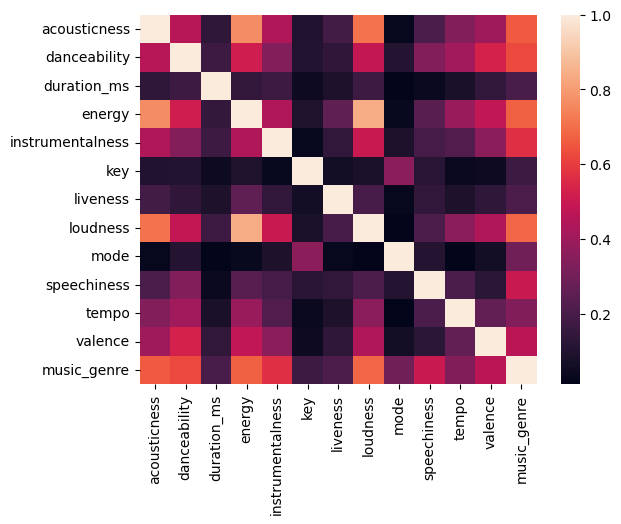

In [35]:
phik_overview = df_train.drop(['track_name'], axis = 1).phik_matrix()
sns.heatmap(phik_overview)

In [36]:
phik_overview['key'].sort_values(ascending = False)

key                 1.000000
mode                0.361356
music_genre         0.170329
speechiness         0.118387
danceability        0.103150
acousticness        0.097669
energy              0.091245
loudness            0.083206
liveness            0.059506
valence             0.044375
duration_ms         0.043172
tempo               0.039136
instrumentalness    0.030172
Name: key, dtype: float64

In [37]:
phik_overview['mode'].sort_values(ascending = False)

mode                1.000000
key                 0.361356
music_genre         0.296208
speechiness         0.104177
danceability        0.103742
instrumentalness    0.084635
valence             0.058115
energy              0.033671
acousticness        0.029148
liveness            0.028823
loudness            0.015827
tempo               0.014283
duration_ms         0.010586
Name: mode, dtype: float64

Согласно таблицы кореляции поля `mode`, `key` зависят друг от друга, заменим пропуски в mode наиболее частым значением по группам key

In [38]:
key_mode = df_train.groupby(['key', 'mode'])['track_name'].agg('count').reset_index()
key_mode = key_mode.rename(columns = {'track_name':'count'})
key_mode['count_max'] = key_mode.groupby(['key'])['count'].transform(max)
key_mode = key_mode[key_mode['count'] == key_mode['count_max']][['key', 'mode']]
dict_mode = dict(key_mode.values)
dict_mode

{'A': 'Major',
 'A#': 'Minor',
 'B': 'Minor',
 'C': 'Major',
 'C#': 'Major',
 'D': 'Major',
 'D#': 'Major',
 'E': 'Minor',
 'F': 'Major',
 'F#': 'Major',
 'G': 'Major',
 'G#': 'Major'}

In [39]:
def get_mode(x):
    if x['key'] in dict_mode and x['mode'] != x['mode']:
        return dict_mode[x['key']]
    
    return x['mode']

In [40]:
df_train['mode'] = df_train.apply(get_mode, axis=1)

In [41]:
df_train['mode'] = df_train['mode'].fillna('unknow')
df_train['key'] = df_train['key'].fillna('unknow')

In [42]:
phik_overview['tempo'].sort_values(ascending = False)

tempo               1.000000
danceability        0.407461
energy              0.387020
loudness            0.357615
acousticness        0.336114
music_genre         0.332854
valence             0.261721
instrumentalness    0.218492
speechiness         0.206594
liveness            0.084353
duration_ms         0.080049
key                 0.039136
mode                0.014283
Name: tempo, dtype: float64

Поле `tempo` зависит от `danceability` поэтому заменим пропуски `tempo` заменим медианным значением сгруппированным по `danceability`

In [43]:
df_train['danceability_cut'] = pd.cut(df_train['danceability'], 100)
tempo_median = df_train.groupby('danceability_cut')['tempo'].agg(['median']).reset_index()
dict_tempo = dict(tempo_median.values)
dict_tempo

{Interval(0.0591, 0.0692, closed='right'): 65.919,
 Interval(0.0692, 0.0784, closed='right'): 79.47,
 Interval(0.0784, 0.0875, closed='right'): 80.9025,
 Interval(0.0875, 0.0967, closed='right'): 79.113,
 Interval(0.0967, 0.106, closed='right'): 88.279,
 Interval(0.106, 0.115, closed='right'): 78.945,
 Interval(0.115, 0.124, closed='right'): 83.04400000000001,
 Interval(0.124, 0.133, closed='right'): 83.167,
 Interval(0.133, 0.143, closed='right'): 82.86599999999999,
 Interval(0.143, 0.152, closed='right'): 90.317,
 Interval(0.152, 0.161, closed='right'): 95.4445,
 Interval(0.161, 0.17, closed='right'): 102.041,
 Interval(0.17, 0.179, closed='right'): 90.305,
 Interval(0.179, 0.189, closed='right'): 109.436,
 Interval(0.189, 0.198, closed='right'): 92.665,
 Interval(0.198, 0.207, closed='right'): 92.105,
 Interval(0.207, 0.216, closed='right'): 98.554,
 Interval(0.216, 0.225, closed='right'): 100.76599999999999,
 Interval(0.225, 0.234, closed='right'): 94.749,
 Interval(0.234, 0.244, c

In [44]:
def get_tempo(x):
    if x['tempo'] != x['tempo']:
        for key in dict_tempo:
            if x['danceability'] in key:
                return dict_tempo[key]
    return x['tempo']

In [45]:
#df_train['tempo'] = df_train.groupby('danceability_qcut')['tempo'].transform(lambda x: x.fillna(x.median()))
df_train['tempo'] = df_train.apply(get_tempo, axis=1)

In [46]:
df_train = df_train.drop(['danceability_cut'], axis = 1)

## Разведочный анализ

In [105]:
phik_overview = df_train.phik_matrix()
phik_overview['music_genre'].sort_values(ascending = False)

interval columns not set, guessing: ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']


music_genre         1.000000
loudness            0.679373
energy              0.669229
acousticness        0.657662
danceability        0.623229
instrumentalness    0.567725
track_name          0.558960
speechiness         0.498089
valence             0.464352
tempo               0.329203
mode                0.255719
liveness            0.208910
duration_ms         0.200636
key                 0.169044
Name: music_genre, dtype: float64

Видим зависимость жанра от `loudness`, `energy`, `acousticness`, `danceability` более подробно посмотрим на данные. 

In [106]:
px.histogram(df_train, x='loudness', title = 'Гистограмма loudness', marginal = 'box')

In [107]:
px.histogram(df_train, x='energy', title = 'Гистограмма energy', marginal = 'box')

In [108]:
px.histogram(df_train, x='danceability', title = 'Гистограмма danceability', marginal = 'box')

In [109]:
px.histogram(df_train, x='acousticness', title = 'Гистограмма acousticness', marginal = 'box')

## Разработка новых синтетических признаков

Добавим признак имеются ли в названии песни символы `\p{Han}`

In [47]:
def serch_han_name(track_name):
    if regex.search(r'\p{Han}', track_name):
        return 1
    return 0

In [48]:
df_train['is_han_name'] = df_train['track_name'].apply(serch_han_name)
df_test['is_han_name'] = df_test['track_name'].apply(serch_han_name)

Добавим признак что в названии есть `feat`

In [49]:
def serch_feat_name(track_name):
    if regex.search(r'\bfeat\b', track_name.lower()):
        return 1
    return 0

In [50]:
df_train['is_feat_name'] = df_train['track_name'].apply(serch_feat_name)
df_test['is_feat_name'] = df_test['track_name'].apply(serch_feat_name)

Добавим длину названия трека

In [51]:
df_train['name_lenght'] = df_train['track_name'].str.len()
df_test['name_lenght'] = df_test['track_name'].str.len()

## Проверка на мультиколлинеарность

## Отбор финального набора обучающих признаков

In [52]:
df_train = df_train.drop(['track_name'], axis=1).reset_index(drop=True)

In [53]:
features_train = df_train.drop(['music_genre'], axis=1)
target_train = df_train['music_genre']

In [54]:
display(features_train.shape)

(20393, 15)

## Выбор и обучение моделей

### Модель LogisticRegression

In [118]:
oe_features_lr = features_train.select_dtypes(include='object').columns.to_list()
oe_features_lr.remove('mode')
oe_features_lr.append('is_han_name')
oe_features_lr.append('is_feat_name')
oe_features_lr

['key', 'is_han_name', 'is_feat_name']

In [53]:
line_transformer = make_column_transformer(
    (
        OneHotEncoder(
            dtype='int16',
            drop='first',
            handle_unknown='ignore'
        ), make_column_selector(dtype_include='object')
    ),
    (
        StandardScaler(
        ), make_column_selector(dtype_include='number')
    ),
    remainder='passthrough'
)

pipe_lr = make_pipeline(
    line_transformer,
    LogisticRegression(
        multi_class = 'multinomial',
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
)

param_grid = {
    'logisticregression__solver':['newton-cg', 'lbfgs', 'sag', 'saga'],
    'logisticregression__C':[.001, .01],
    'logisticregression__max_iter':[500, 1000]
}

gs_lr = GridSearchCV(
    pipe_lr,
    param_grid,
    scoring={'f1_micro':'f1_micro'},
    n_jobs=-1,
    verbose=1,
    refit='f1_micro'
)

In [54]:
features_columns_lr = features_train.columns.tolist()
features_columns_lr.remove('mode')

%time gs_lr.fit(features_train[features_columns_lr], target_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Wall time: 13.9 s


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       dtype='int16',
                                                                                       handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000278F14F33A0>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_trans..

In [55]:
print(f'best_score: {gs_lr.best_score_}')
print(f'best_params: {gs_lr.best_params_}')

best_score: 0.4151915798343193
best_params: {'logisticregression__C': 0.01, 'logisticregression__max_iter': 500, 'logisticregression__solver': 'newton-cg'}


### Модель RandomForestClassifier

In [37]:
oe_features_rf = features_train.select_dtypes(include='object').columns.to_list()
oe_features_rf.append('is_han_name')
oe_features_rf.append('is_feat_name')
oe_features_rf

['key', 'mode', 'is_han_name', 'is_feat_name']

In [38]:
transformer_rf = make_column_transformer(
    (
        OneHotEncoder(
            dtype='int16',
            drop='first',
            handle_unknown='ignore'
        ), oe_features_rf
    ),
    remainder='passthrough'
)

pipe_rf = make_pipeline(
    transformer_rf,
    RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
)

param_grid = {
    'randomforestclassifier__n_estimators':np.arange(100, 300, 50),
    'randomforestclassifier__max_depth':np.arange(1, 20, 2),
}

gs_rf = GridSearchCV(
    pipe_rf,
    param_grid,
    scoring={'f1_micro':'f1_micro'},
    n_jobs=-1,
    verbose=1,
    refit='f1_micro'
)

In [39]:
%time gs_rf.fit(features_train, target_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Wall time: 2min 3s


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       dtype='int16',
                                                                                       handle_unknown='ignore'),
                                                                         ['key',
                                                                          'mode',
                                                                          'is_han_name',
                                                                          'is_feat_name'])])),
                                       ('randomforestclassifier',
                                     

In [40]:
print(f'best_score: {gs_rf.best_score_}')
print(f'best_params: {gs_rf.best_params_}')

best_score: 0.4833526690433819
best_params: {'randomforestclassifier__max_depth': 13, 'randomforestclassifier__n_estimators': 250}


### Модель CatBoostClassifier

In [41]:
cat_features = ['key','mode', 'is_han_name', 'is_feat_name']
model_cb_gs = CatBoostClassifier(loss_function='MultiClass',
                                eval_metric='TotalF1',
                                random_seed=RANDOM_STATE,
                                verbose=200,
                                task_type="GPU",
                                
                               )
cat_pool = Pool(data=features_train,
                label=target_train,
                cat_features=cat_features)

grid = {'learning_rate': [0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}


grid_search_result = model_cb_gs.grid_search(grid,
                                            X=cat_pool,
                                            #y=target_train,
                                            plot=True,
                                            cv = 5,
                                            shuffle=True,
                                            partition_random_seed=RANDOM_STATE,
                                            stratified=True
                                           )


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2677068	test: 0.2527285	best: 0.2527285 (0)	total: 15.7ms	remaining: 15.6s
200:	learn: 0.5051862	test: 0.4615083	best: 0.4623295 (195)	total: 2.9s	remaining: 11.5s
400:	learn: 0.5474204	test: 0.4659051	best: 0.4665490 (397)	total: 5.75s	remaining: 8.58s
600:	learn: 0.5888167	test: 0.4720961	best: 0.4722277 (599)	total: 8.7s	remaining: 5.78s
800:	learn: 0.6232910	test: 0.4737044	best: 0.4777090 (743)	total: 12.2s	remaining: 3.04s
999:	learn: 0.6574544	test: 0.4780216	best: 0.4784741 (828)	total: 16.3s	remaining: 0us
bestTest = 0.4784740833
bestIteration = 828
0:	loss: 0.4784741	best: 0.4784741 (0)	total: 16.6s	remaining: 3m 52s
0:	learn: 0.2677068	test: 0.2527285	best: 0.2527285 (0)	total: 23.7ms	remaining: 23.7s
200:	learn: 0.4989304	test: 0.4596388	best: 0.4604543 (193)	total: 4.1s	remaining: 16.3s
400:	learn: 0.5363923	test: 0.4647827	best: 0.4649907 (396)	total: 8.26s	remaining: 12.3s
600:	learn: 0.5650050	test: 0.4706357	best: 0.4727357 (571)	total: 12.4s	remaining: 8.2

999:	learn: 0.9904911	test: 0.4638755	best: 0.4727502 (177)	total: 1m 29s	remaining: 0us
bestTest = 0.4727501735
bestIteration = 177
12:	loss: 0.4727502	best: 0.4831259 (7)	total: 7m 47s	remaining: 1m 11s
0:	learn: 0.3748918	test: 0.3506834	best: 0.3506834 (0)	total: 81.4ms	remaining: 1m 21s
200:	learn: 0.6829665	test: 0.4687843	best: 0.4711302 (159)	total: 17.4s	remaining: 1m 9s
400:	learn: 0.8452314	test: 0.4717193	best: 0.4723426 (399)	total: 35.1s	remaining: 52.4s
600:	learn: 0.9326430	test: 0.4655469	best: 0.4732692 (491)	total: 52.6s	remaining: 34.9s
800:	learn: 0.9731940	test: 0.4650153	best: 0.4732692 (491)	total: 1m 10s	remaining: 17.5s
999:	learn: 0.9853936	test: 0.4613895	best: 0.4732692 (491)	total: 1m 27s	remaining: 0us
bestTest = 0.4732691722
bestIteration = 491
13:	loss: 0.4732692	best: 0.4831259 (7)	total: 9m 15s	remaining: 39.7s
0:	learn: 0.3748918	test: 0.3506834	best: 0.3506834 (0)	total: 80.6ms	remaining: 1m 20s
200:	learn: 0.6536405	test: 0.4643902	best: 0.4685587 

In [42]:
grid_search_result['params']

{'depth': 6, 'l2_leaf_reg': 5, 'learning_rate': 0.1}

In [55]:
cat_features = ['key','mode', 'is_han_name', 'is_feat_name']

train_cbm, test_cbm = train_test_split(df_train, test_size=0.25, random_state=RANDOM_STATE, stratify=df_train['music_genre'])
features_train_cbm = train_cbm.drop(['music_genre'], axis=1)
target_train_cbm = train_cbm['music_genre']
features_test_cbm = test_cbm.drop(['music_genre'], axis=1)
target_test_cbm = test_cbm['music_genre']


model_cb_best_param = CatBoostClassifier(loss_function='MultiClass',
                           eval_metric='TotalF1',
                           random_seed=RANDOM_STATE,
                           learning_rate=0.1,
                           depth = 6,
                           l2_leaf_reg = 9,
                           task_type="GPU")
model_cb_best_param.fit(
    X=features_train_cbm, 
    y=target_train_cbm,
    cat_features=cat_features,
    eval_set=(features_test_cbm, target_test_cbm),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [57]:
target_test_bad = target_test_cbm.to_frame()

In [58]:
target_test_bad['predict'] = model_cb_best_param.predict(features_test_cbm)

In [59]:
target_test_bad[target_test_bad['music_genre'] != target_test_bad['predict']]['music_genre'].value_counts()

Rock           452
Alternative    422
Blues          285
Hip-Hop        257
Country        233
Jazz           211
Anime          205
Rap            196
Electronic     196
Classical       68
Name: music_genre, dtype: int64

## Итоговая оценка качества предсказания лучшей модели

In [60]:
best_model = model_cb_best_param

Обработаем пропуски в тестовых данных

In [61]:
df_test['mode'] = df_test.apply(get_mode, axis=1)
df_test['tempo'] = df_test.apply(get_tempo, axis=1)
df_test['mode'] = df_test['mode'].fillna('unknow')
df_test['key'] = df_test['key'].fillna('unknow')

In [120]:
#df_test['danceability_cut'] = pd.cut(df_test['danceability'], 100)
#df_test['tempo'] = df_test.groupby('danceability_cut')['tempo'].transform(lambda x: x.fillna(x.median()))

In [62]:
colum_name = df_train.columns.tolist()
colum_name.remove('music_genre')
colum_name

['acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'speechiness',
 'tempo',
 'valence',
 'is_han_name',
 'is_feat_name',
 'name_lenght']

In [63]:
X_test = df_test[colum_name]
test_pool = Pool(data=X_test, cat_features=cat_features)
music_genre = best_model.predict(test_pool)
print('Predictoins:')
print(music_genre)

Predictoins:
[['Rap']
 ['Blues']
 ['Rap']
 ...
 ['Rap']
 ['Electronic']
 ['Blues']]


In [64]:
f = open('submit5.csv', 'w')
f.write('instance_id,music_genre\n')
for idx in range(len(music_genre)):
    line = str(df_test['instance_id'][idx]) + ',' + str(music_genre[idx][0]) + '\n'
    f.write(line)
f.close()

## Анализ важности ее признаков.

In [65]:
best_model.get_feature_importance(prettified=True)

Feature Id  Importances
0        speechiness    14.612710
1   instrumentalness    12.488849
2       danceability    11.782394
3       acousticness     8.761433
4           loudness     8.244474
5            valence     8.115566
6        duration_ms     6.715301
7             energy     6.010143
8        name_lenght     5.461649
9              tempo     5.409407
10               key     4.253084
11          liveness     3.911728
12              mode     2.707471
13       is_han_name     0.782656
14      is_feat_name     0.743135